In [1]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

In [2]:
# Using Random Forest to Classify if target is above income threshold

# Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
X_train['AGEP'] = StandardScaler().fit_transform(X_train[['AGEP']])
X_test['AGEP'] = StandardScaler().fit_transform(X_test[['AGEP']])


In [139]:
def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test, threshold1, threshold2):
    global s1, s2, preds_s1, preds_s2, true_s1, true_s2, fpr1, tpr1, thresholds1, fpr2, tpr2, thresholds2, scores_s1, scores_s2   
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    # Modify pipeline to fulfill one of the fairness criteria (e.g. statistical parity, equal opportunity, etc.)
    X_test = X_test.reset_index(drop=True)
    s2 = X_test.query("SEX_2 == True")
    s1 = X_test.query("SEX_2 == False")

    true_s1 = []
    for i in s1.index:
        true_s1.append(y_test[i])
    true_s2 = []
    for i in s2.index:
        true_s2.append(y_test[i])


    scores_s1 = pipeline.predict_proba(s1)[:, 1]
    fpr1, tpr1, thresholds1 = roc_curve(true_s1, scores_s1, pos_label=1)
    scores_s2 = pipeline.predict_proba(s2)[:, 1]
    fpr2, tpr2, thresholds2 = roc_curve(true_s2, scores_s2, pos_label=1)


    preds_s1 = scores_s1 > threshold1
    preds_s2 = scores_s2 > threshold2
    return pipeline

In [140]:
rf_args = {
    'n_estimators': 100, # changed from 100
    'max_depth' : 10, #changed from 10
    'min_samples_split': 2, #changed from 2
    'min_samples_leaf': 2, #changed from 2
    'random_state': 0
}
lr_model = LogisticRegression(max_iter=5000, penalty= "l2", C= 0.8497534359086438, tol=1e-4, solver = "saga")
p1 = make_pipeline(RandomForestClassifier(**rf_args))
p2 = make_pipeline(lr_model)


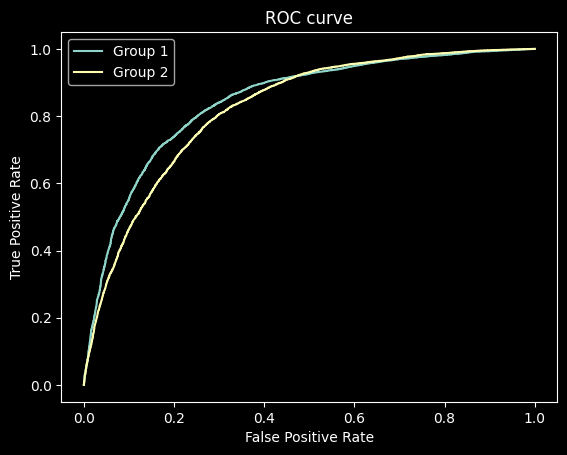

Accuracy for group 1:  0.7626206294554095
Accuracy for group 2:  0.7519987035436474
Selection rate for s1:  0.5270840405411958
Selection rate for s2:  0.5486171132238548


In [141]:
p1_done = evaluate_pipeline(p2, X_train, y_train, X_test, y_test, 0.4, optimal_threshold2)
plt.plot(fpr1, tpr1, label='Group 1')
plt.plot(fpr2, tpr2, label='Group 2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Calculate Youden's J statistic for each model
youden_j1 = tpr1 - fpr1
optimal_threshold_index1 = np.argmax(youden_j1)
optimal_threshold1 = thresholds1[optimal_threshold_index1]

youden_j2 = tpr2 - fpr2
optimal_threshold_index2 = np.argmax(youden_j2)
optimal_threshold2 = thresholds2[optimal_threshold_index2]
preds_s1 = scores_s1 > 0.66 # 0.66 best 
preds_s2 = scores_s2 > optimal_threshold2 # 0.4756088801681863 best
# Compare outcomes across groups

print("Accuracy for group 1: ", accuracy_score(true_s1, preds_s1))
print("Accuracy for group 2: ", accuracy_score(true_s2, preds_s2))

print('Selection rate for s1: ', np.sum(preds_s1)/len(s1))
print('Selection rate for s2: ', np.sum(preds_s2)/len(s2))

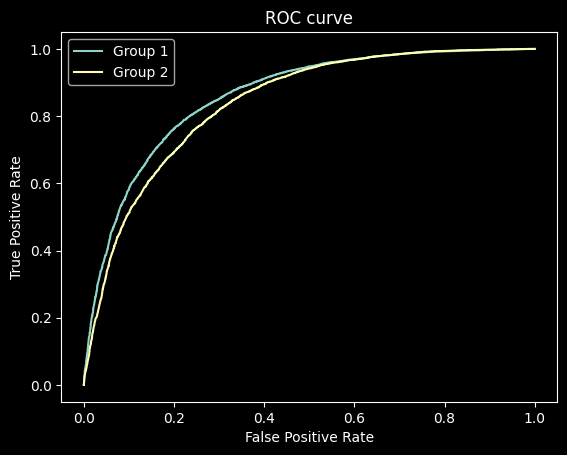

Accuracy for group 1:  0.7561223994956597
Accuracy for group 2:  0.7582649092480553
Selection rate for s1:  0.4889675573444547
Selection rate for s2:  0.557152117545376


In [142]:
p1_done = evaluate_pipeline(p1, X_train, y_train, X_test, y_test, 0.4, optimal_threshold2)

plt.plot(fpr1, tpr1, label='Group 1')
plt.plot(fpr2, tpr2, label='Group 2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Calculate Youden's J statistic for each model
youden_j1 = tpr1 - fpr1
optimal_threshold_index1 = np.argmax(youden_j1)
optimal_threshold1 = thresholds1[optimal_threshold_index1]

youden_j2 = tpr2 - fpr2
optimal_threshold_index2 = np.argmax(youden_j2)
optimal_threshold2 = thresholds2[optimal_threshold_index2]
preds_s1 = scores_s1 > 0.66 # 0.66 best 
preds_s2 = scores_s2 > optimal_threshold2 # 0.4756088801681863 best
# Compare outcomes across groups

print("Accuracy for group 1: ", accuracy_score(true_s1, preds_s1))
print("Accuracy for group 2: ", accuracy_score(true_s2, preds_s2))

print('Selection rate for s1: ', np.sum(preds_s1)/len(s1))
print('Selection rate for s2: ', np.sum(preds_s2)/len(s2))